In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

In [2]:
import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [3]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=6)

In [4]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [5]:
client

Client Scheduler: tcp://10.148.0.146:45438 Dashboard: http://10.148.0.146:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp6_m1a1_4km_500a1000j/'

In [42]:

cluster.scale(jobs=6)

In [43]:
client.restart()

Client Scheduler: tcp://10.148.0.185:56288 Dashboard: http://10.148.0.185:8787/status,Cluster Workers: 28 Cores: 28 Memory: 479.92 GB


In [44]:
eulerian_field = xr.open_dataset(root_path+run+'diagnostics/ZC_Eulerian_field.nc').persist()

### Lagrangian

In [7]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   537.68750  22.758894  148.14916   50.0  0.446419  24.580401  0.091750   
1   564.13889  28.742945  152.88084   50.0  0.505317  24.581235  0.005618   
1   522.47222  18.204193  148.83319   50.0  0.456145  24.579770 -0.063668   
1   522.47917  18.194805  148.83848   50.0  0.458741  24.579761 -0.061416   
1   564.13194  28.742371  152.86181   50.0  0.506675  24.581228 -0.001241   

           v      dudt      dvdt      pres           x          y  
id                                                                 
1  -0.022738 -0.000001 -0.000016  5.254484   91.035576  592.59664  
1   0.119963  0.000012 -0.000005  5.832322  114.971780  611.52336  
1   0.038755  0.000003  0.000018  5.349879   72.816772  595.33276  
1   0.049446  0.000004  0.000018  5.375339   72.779220  595.35392  
1   0.122525  0.000012 -0.000003  5.845649  114.9694

#### Eulerian

In [46]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_counter': 'time'})

In [47]:
V = ['u', 'v','ssh']
dij = 1
dti = 1
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 54 GB


In [48]:
x,y,t = 'auto', 'auto' , 'auto'
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [49]:
from collections import OrderedDict

def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [50]:
for V in ['u','v']:
    ds[V] = x2rho(ds[V],r.xgrid,'extrapolate')

In [51]:
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:  (time: 24000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
    x_v      (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
  * y_v      (y_v) float32 0.0 4000.0 8000.0 ... 2872000.0 2876000.0 2880000.0
    f_rho    (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f        (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * time     (time) float64 500.0 500.0 500.1 500.1 ... 999.9 1e+03 1e+03 1e+03
    y_u      (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_u      (x_u) float32 0.0 4000.0 8000.0 ... 1016000.0 1020000.0 1024000.0
  * x_rho    (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
Data variables:
    u        (time, y_rho, x_rho) float32 dask.array<chunksize=(800, 344, 1), meta=np.ndarray>
    v        (time, y_rho, x_rho) float32 dask.array<chunksize=(800, 1, 86), meta=np.ndarray>
    ssh      (time, y_rho, x_rho) float32 dask.array<chunksize=(800, 361, 86), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.6
    description:   Created by xios
    name:          surf
    s_rho_slice0:  -0.009999999776482582
    timeStamp:     2020-Apr-29 06:22:08 GMT
    title:         Created by xios
    uuid:          712a6480-0041-49d6-9a24-d3dbda3f6895

In [52]:

tmid = 750#(t0+t1)/2
t0 = tmid-7.5
t1 = tmid+7.5
imid = (tmid-500)*24*6

In [62]:
df = dr.df.reset_index()
df = df.set_index('time').persist()

In [63]:
#df = dr.df.loc[225].compute()
dsi = ds.u.isel(time=250*24*2).persist()

In [56]:
dfx = (df.x.loc[750]*1e3).compute()
dfy = (df.y.loc[750]*1e3).compute()

In [57]:
KE = np.sqrt(ds.u**2+ds.v**2)

### Fig 1 : Presentation of the simulation

Text(0.5, 1.0, 'Time=750 days')

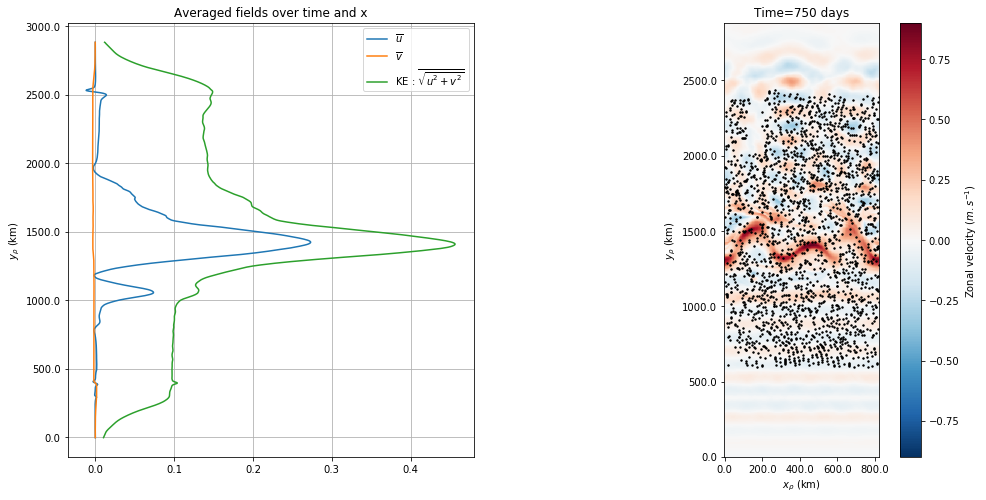

In [58]:
fig,axs= plt.subplots(1,2,figsize=(16,8))
ax = axs[0]
ds.u.mean(['time','x_rho']).plot(ax=ax,y='y_rho',label=r'$\overline{u}$')
ds.v.mean(['time','x_rho']).plot(ax=ax,y='y_rho',label=r'$\overline{v}$')
KE.mean(['time','x_rho']).plot(ax=ax,y='y_rho',label=r'KE : $\overline{\sqrt{u^2+v^2}}$')
laby = ax.get_yticks();laby = [str(l*1e-3) for l in laby];
ax.set_yticklabels(laby)
ax.set_ylabel(r'$y_\rho$ (km)')#;ax.set_xlabel(r'$x_\rho$ (km)')
ax.grid();ax.legend();ax.set_title(r'Averaged fields over time and x')
ax = axs[1]
dsi.plot(ax=ax,cbar_kwargs={'label':r'Zonal velocity ($m.s^{-1}$)'})
labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
ax.set_yticklabels(laby);ax.set_xticklabels(labx)
ax.set_ylabel(r'$y_\rho$ (km)');ax.set_xlabel(r'$x_\rho$ (km)')
#ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3)
#ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color='r',markeredgecolor='w');
#ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color='b',markeredgecolor='w')
ax.scatter(dfx[::4],dfy[::4],s=2,c='k')
ax.set_aspect('equal')
ax.set_title('Time=%s days'%750)
#fig.savefig('/home1/datawork/zcaspar/Figs/drifters_simu.png')

#### Comments : 
Left : \
Mean zonal velocity (average over time and x axis)\
Averaged KE (computed using the entire velocity) : peak in the jet and energy in the northern area\
Right : \
Zonal velocity at mid time (1750days) and distribution of 1/4 of the drifters at that time\
we can see the jet and the internal tides in u. It also illustrates the fact that we don"t seem have areas without drifters 

In [65]:
df_loc = df.loc[750].compute()
df_loc = df_loc.sort_values('y').set_index('y')

In [66]:
id_north = df_loc.loc[2290:2310].id.values[int(df_loc.loc[2290:2310].id.size/2)]
id_south = df_loc.loc[690:710].id.values[int(df_loc.loc[690:710].id.size/2)]
id_jet = df_loc.loc[1490:1510].id.values[int(df_loc.loc[1490:1510].id.size/2)]

In [67]:
df_jet = dr.df.loc[id_jet].compute()
df_north = dr.df.loc[id_north].compute()
df_south = dr.df.loc[id_south].compute()

### Fig 2 : trajectory of 3 drifters in three areas (south, jet and north) over 15 days

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


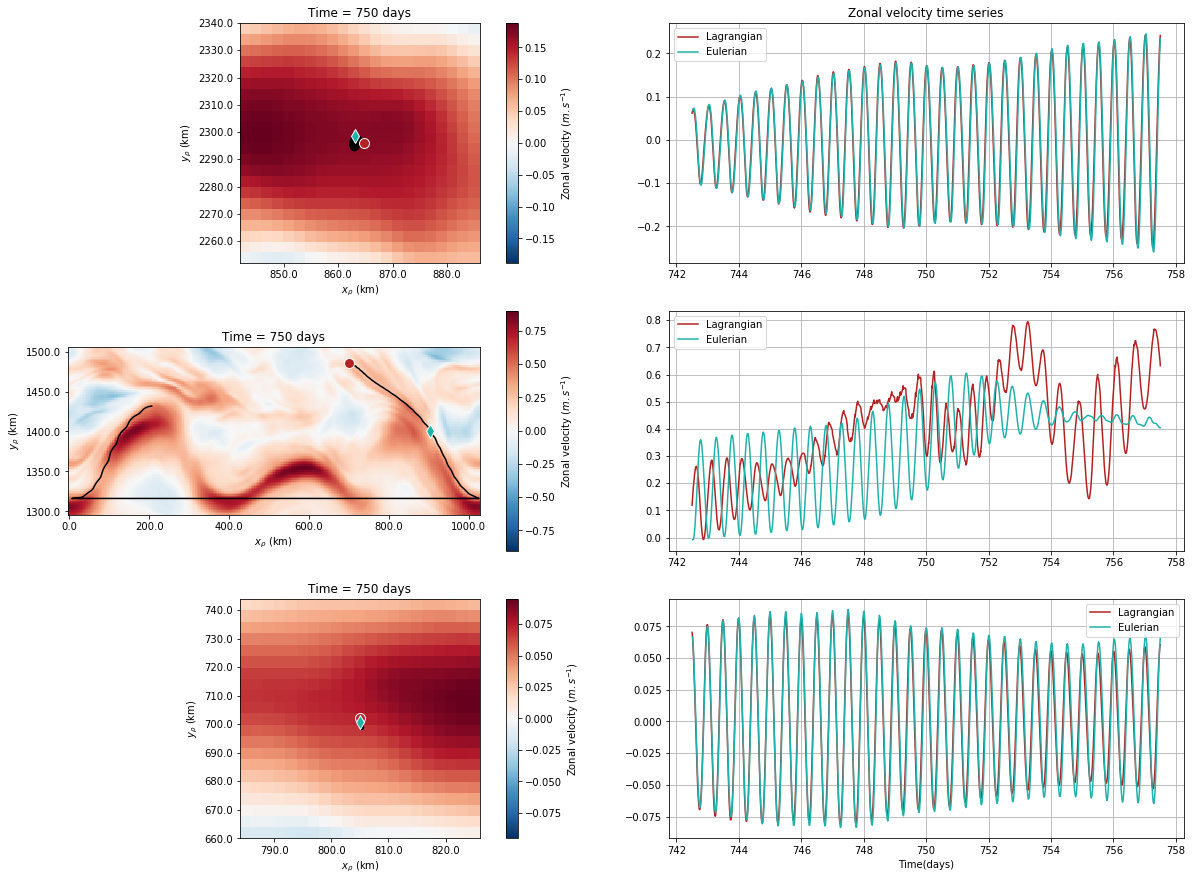

In [68]:
ce = 'lightseagreen'
cl = 'firebrick'
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.2)
for df,i in zip([df_north,df_jet,df_south],range(3)):
    df =df.sort_values('time').set_index('time')
    ds_zoom = ds.u.sel(x_rho = slice((df.x.loc[t0:t1].min()-40)*1e3,(df.x.loc[t0:t1].max()+40)*1e3),
                       y_rho = slice((df.y.loc[t0:t1].min()-40)*1e3,(df.y.loc[t0:t1].max()+40)*1e3)).persist()
    #ds_zoom = ds_zoom.isel(time=57*24*6).compute()
    ax = plt.subplot(grid[i,:2])
    ds_zoom.isel(time=250*24*2).plot(ax=ax,cbar_kwargs={'label':r'Zonal velocity ($m.s^{-1}$)'})#.isel(time=57*24*6).plot(ax=ax)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.set_ylabel(r'$y_\rho$ (km)');ax.set_xlabel(r'$x_\rho$ (km)')
    ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3,'k')
    ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color=cl,markeredgecolor='w',ms=10);
    ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color=ce,markeredgecolor='w',ms=10)
    ax.set_aspect('equal');ax.set_title('Time = %s days'%tmid)
    ax=plt.subplot(grid[i,2:])
    df.u.loc[t0:t1].plot(ax=ax,c=cl,label='Lagrangian')
    ds_zoom.sel(x_rho=df.x.loc[tmid]*1e3,y_rho=df.y.loc[tmid]*1e3,method='nearest').isel(time=slice(int(242.5*24*2),int(257.5*24*2))).plot(ax=ax,label='Eulerian',c=ce)
    ax.legend();ax.set_ylabel('');ax.grid();ax.set_xlabel('');ax.set_title('')
ax.set_xlabel('Time(days)');
ax=plt.subplot(grid[0,2:])
ax.set_title('Zonal velocity time series')
fig.tight_layout()

#### Comments:
The trajectory of the dirfter is in black. The background represents the zonal velocity at t=1750days. The red point corresponds to the position of the drifter at t0 and the blue one to the position at t=1750d.\
The time series in the right panels are the ones along the drifter trajectory (in red) and at the blue point (fixed eulerian time series).

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


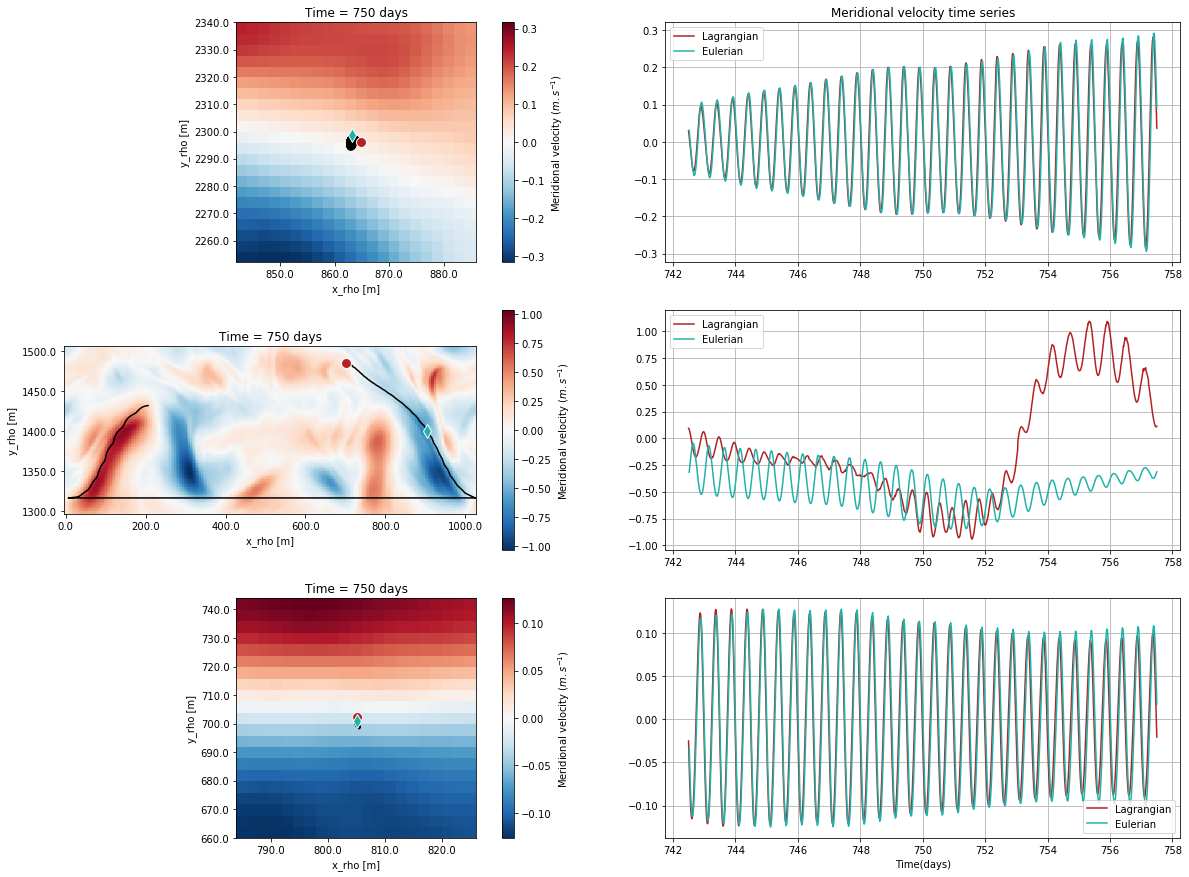

In [69]:
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.2)
for df,i in zip([df_north,df_jet,df_south],range(3)):
    df =df.sort_values('time').set_index('time')
    ds_zoom = ds.v.sel(x_rho = slice((df.x.loc[t0:t1].min()-40)*1e3,(df.x.loc[t0:t1].max()+40)*1e3),
                       y_rho = slice((df.y.loc[t0:t1].min()-40)*1e3,(df.y.loc[t0:t1].max()+40)*1e3)).persist()
    #ds_zoom = ds_zoom.isel(time=57*24*6).compute()
    ax = plt.subplot(grid[i,:2])
    ds_zoom.isel(time=250*24*2).plot(ax=ax,cbar_kwargs={'label':r'Meridional velocity ($m.s^{-1}$)'})#.isel(time=57*24*6).plot(ax=ax)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3,'k')
    ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color=cl,markeredgecolor='w',ms=10);
    ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color=ce,markeredgecolor='w',ms=10)
    ax.set_aspect('equal');ax.set_title('Time = %s days'%tmid)
    ax=plt.subplot(grid[i,2:])
    df.v.loc[t0:t1].plot(ax=ax,c=cl,label='Lagrangian')
    ds_zoom.sel(x_rho=df.x.loc[tmid]*1e3,y_rho=df.y.loc[tmid]*1e3,method='nearest').isel(time=slice(int(242.5*24*2),int(257.5*24*2))).plot(ax=ax,label='Eulerian',c=ce)
    ax.legend();ax.set_ylabel('');ax.grid();ax.set_xlabel('');ax.set_title('')
ax.set_xlabel('Time(days)');
ax=plt.subplot(grid[0,2:])
ax.set_title('Meridional velocity time series')
fig.tight_layout()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


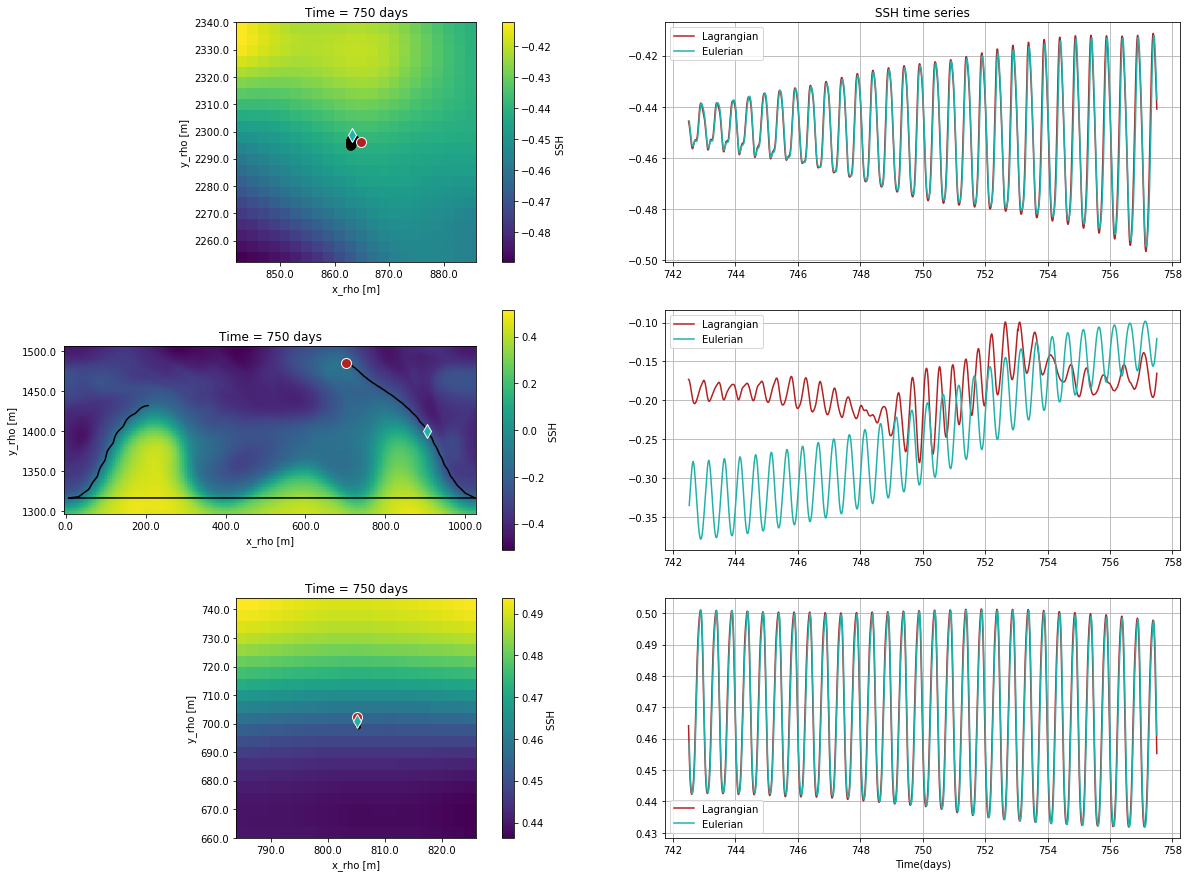

In [70]:
cmap = 'viridis'
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.2)
for df,i in zip([df_north,df_jet,df_south],range(3)):
    df =df.sort_values('time').set_index('time')
    ds_zoom = ds.ssh.sel(x_rho = slice((df.x.loc[t0:t1].min()-40)*1e3,(df.x.loc[t0:t1].max()+40)*1e3),
                       y_rho = slice((df.y.loc[t0:t1].min()-40)*1e3,(df.y.loc[t0:t1].max()+40)*1e3)).persist()
    #ds_zoom = ds_zoom.isel(time=57*24*6).compute()
    ax = plt.subplot(grid[i,:2])
    ds_zoom.isel(time=250*24*2).plot(ax=ax,cmap=cmap,cbar_kwargs={'label':r'SSH '})#.isel(time=57*24*6).plot(ax=ax)
    labx,laby = ax.get_xticks(),ax.get_yticks();labx,laby = [str(l*1e-3) for l in labx],[str(l*1e-3) for l in laby];
    ax.set_xticklabels(labx);ax.set_yticklabels(laby)
    ax.plot(df.x.loc[t0:t1]*1e3,df.y.loc[t0:t1]*1e3,'k')
    ax.plot(df.x.loc[t0]*1e3,df.y.loc[t0]*1e3,marker='o',color=cl,markeredgecolor='w',ms=10);
    ax.plot(df.x.loc[tmid]*1e3,df.y.loc[tmid]*1e3,marker='d',color=ce,markeredgecolor='w',ms=10)
    ax.set_aspect('equal');ax.set_title('Time = %s days'%tmid)
    ax=plt.subplot(grid[i,2:])
    df.depth.loc[t0:t1].plot(ax=ax,c=cl,label='Lagrangian')
    ds_zoom.sel(x_rho=df.x.loc[tmid]*1e3,y_rho=df.y.loc[tmid]*1e3,method='nearest').isel(time=slice(int(242.5*24*2),int(257.5*24*2))).plot(ax=ax,label='Eulerian',c=ce)
    ax.legend();ax.set_ylabel('');ax.grid();ax.set_xlabel('');ax.set_title('')
ax.set_xlabel('Time(days)');
ax=plt.subplot(grid[0,2:])
ax.set_title('SSH time series')
fig.tight_layout()


#### Comments : 
The 2 previous figures areonly there for information and to keep an eye on what happen for other variables

In [9]:
def diags_dist(v1,v2,v3,v4,N):
#    fltI = flt.sel(time=slice(Ti,Tf))
    if v1 is None and v2 is None:
        return pd.Series(np.random.randn(N),index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])
    else : 
        dxint = np.abs(v3).mean()#np.diff(np.unwrap(v1)).sum()
        dyint = np.abs(v4).mean()#np.diff(v2).sum()
        dsint = np.sqrt(v3**2+v4**2).mean()#np.diff(np.unwrap(v1))**2+np.diff(v2)**2).sum()
        return pd.Series([np.unwrap(v1).max(),np.unwrap(v1).min(),v2.max(),v2.min(),v2.iloc[0],v2.iloc[-1],dxint,dyint,dsint],
                         index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])#,fltI.v

In [14]:
def apply_window(myfun,columns,T,N,L,binsize):
    """Compute diags_dist and returns xarray"""
    df_chunked = dr.df.groupby(dr.df.index).apply(cdr.time_window_processing, myfun, 
                                                  columns,T,N,L
                                                 ).persist()
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y0_cut'] = df_chunked['y0'].map_partitions(pd.cut, bins=y_bins)
    df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
    # difference btw y max and min
    df_chunked['ydiff'] = df_chunked['ymax']-df_chunked['ymin']
    # difference btw x max and min
    df_chunked['xdiff'] = df_chunked['xmax']-df_chunked['xmin']
    DF = df_chunked.compute()
    return DF.set_index(DF.y0_cut.map(lambda v: v.mid)).drop(columns=['time','x','y']).rename(columns={'y0_cut':'y0_bins'}).to_xarray()

In [15]:
ds_dist = {}
for T in [10,20,40,80,120]:
    ds_dist['ds_'+str(T)] = apply_window(diags_dist,['x','y','u','v'],T,9,1024,50)
#ds40 = apply_window(diags_dist,['x','y','u','v'],40,9,L,50)
#ds20 = apply_window(diags_dist,['x','y','u','v'],20,9,L,50)
#ds10 = apply_window(diags_dist,['x','y','u','v'],10,9,L,50)
#ds80 = apply_window(diags_dist,['x','y','u','v'],80,9,L,50)
#ds120 = apply_window(diags_dist,['x','y','u','v'],120,9,L,50)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from parti

In [16]:
ds_stats={}
for T in ['10','20','40','80','120']:
    ds_stats[T] = ds_dist['ds_'+str(T)].groupby('y0_cut').mean()
    ds_stats[T]['Tu'] = (float(T)*24*3600*ds_stats[T].dx*1e-3)
    ds_stats[T]['Tv'] = (float(T)*24*3600*ds_stats[T].dy*1e-3)

### Fig 3 : Distance traveled by the drifters for several time window sizes

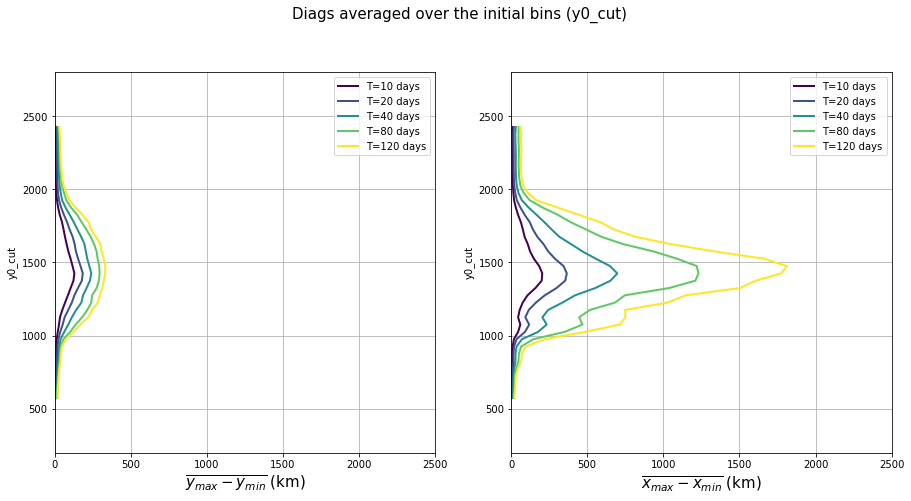

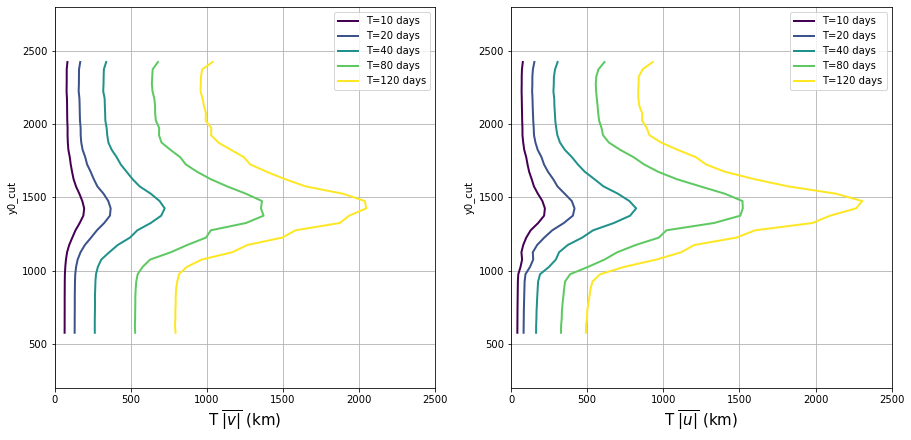

In [17]:
fontsize = 15
number = len(['10','20','40','80','120'])
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

fig,axs = plt.subplots(1,2,figsize=(15,7))
fig.suptitle('Diags averaged over the initial bins (y0_cut)',x=0.5,y=1.01,fontsize=fontsize)
for T,c in zip(ds_stats.keys(),colors):
    for var,lab,ax in zip(['ydiff','xdiff'],[r'$\overline{y_{max}-y_{min}}$ (km)',r'$\overline{x_{max}-x_{min}}$ (km)'],axs):
        ds_stats[T][var].plot(y='y0_cut',ax=ax,c=c,linewidth=2,label='T=%s days'%int(T))
        ax.set_xlabel(lab,fontsize=fontsize)
        ax.legend()
        ax.set_xlim(0,2500);ax.set_ylim(200,2800)
axs[0].grid();axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(15,7))
for T,c in zip(ds_stats.keys(),colors):
    for var,lab, ax in zip(['Tv','Tu'],[r'T $\overline{|v|}$ (km)',r'T $\overline{|u|}$ (km)'],axs):
        ds_stats[T][var].plot(y='y0_cut',ax=ax,c=c,linewidth=2,label='T=%s days'%int(T))
        ax.legend()
        ax.set_xlim(0,2500);ax.set_ylim(200,2800)
        ax.set_xlabel(lab,fontsize=fontsize)
axs[0].grid();axs[1].grid()

#### Comments : 
Not sure where this figure will go yet.\
First line : \
Distance between two extrema in the y and x directions\
Second line : \
Distance that would be covered by the drifters if they just moved in straight line at mean velocity (mean amplitude) during the chosen window size\


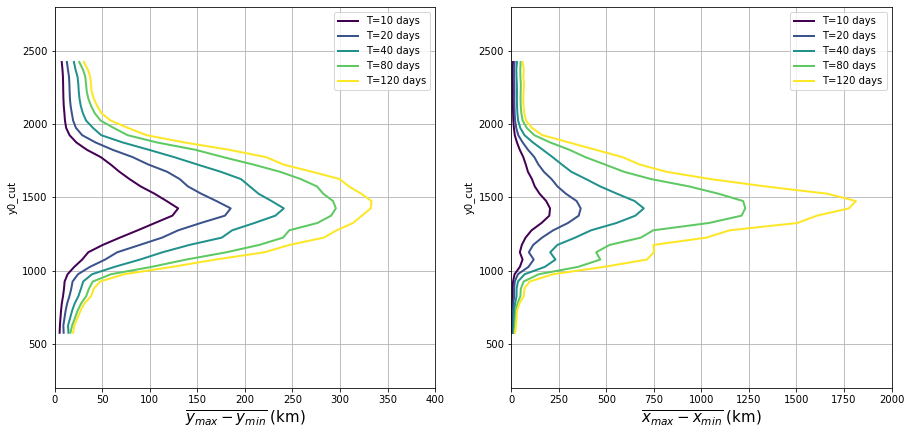

In [19]:
fig,axs = plt.subplots(1,2,figsize=(15,7))

for T,c in zip(ds_stats.keys(),colors):
    for var,lab,ax in zip(['ydiff','xdiff'],[r'$\overline{y_{max}-y_{min}}$ (km)',r'$\overline{x_{max}-x_{min}}$ (km)'],axs):
        ds_stats[T][var].plot(y='y0_cut',ax=ax,c=c,linewidth=2,label='T=%s days'%int(T))
        ax.set_xlabel(lab,fontsize=fontsize)
        ax.legend()
        ax.set_ylim(200,2800)
        ax.grid()
axs[0].set_xlim(0,400);axs[1].set_xlim(0,2000);

#### Comments/notes : 
Zoom of the first line panels in the previous figure. Won't be shown, but will serve to have the values between extrema

### Fig 4 : Comparison to the internal tides scales

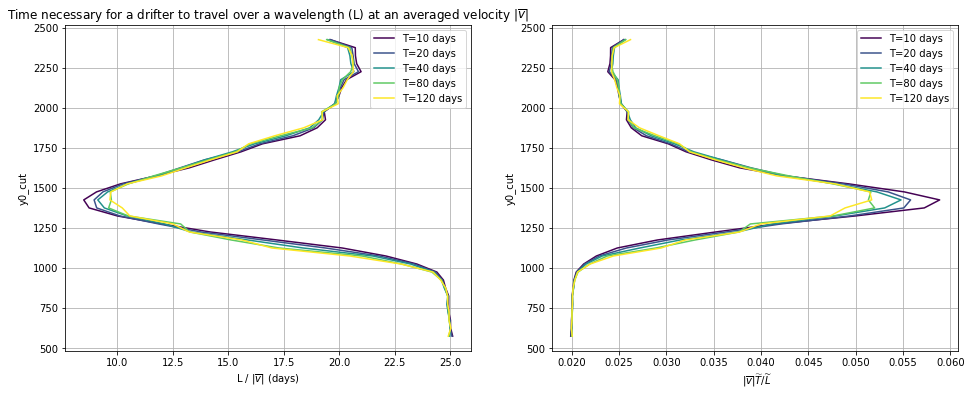

In [20]:
Lbc = 165
Tw = 0.5
fig, ax = plt.subplots(1,2,figsize=(16,6))
for T, c in zip(ds_stats.keys(),colors):
    (Lbc/(24*3600*ds_stats[T].dy*1e-3)).plot(ax=ax[0],y='y0_cut',c=c,label='T=%s days'%int(T))
ax[0].grid();ax[0].set_xlabel(r'L / $\vert\overline{v}\vert$ (days)')
ax[0].set_title(r'Time necessary for a drifter to travel over a wavelength (L) at an averaged velocity $\vert\overline{v}\vert$')
ax[0].legend()
#Tbc = (Lbc/(ds80_stats.dy*1e-3))/24*3600
#Tbc2 = (Lbc/(2*ds80_stats.dy*1e-3))/24*3600

for T, c in zip(ds_stats.keys(),colors):
    (Tw*(24*3600*ds_stats[T].dy*1e-3)/Lbc).plot(ax=ax[1],y='y0_cut',c=c,label='T=%s days'%int(T))
ax[1].grid();ax[1].set_xlabel(r' $\vert\overline{v}\vert\widetilde{T}/\widetilde{L}$')
#ax.set_title(r'Time necessary for a drifter to travel over a wavelength (L) at an averaged velocity $\vert\overline{v}\vert$')
ax[1].legend()

#### Comments/notes : 
Left : \
Time a drifter will need to travel the distance equivalent to one wavelength.\
Right : \
$\beta$ parameter : is the same than normalizing the previous parameter by the period of the waves.

### Autocorrelations T=40days

In [105]:
path = root_path+run+'diagnostics/' #datarmor
#path = '/Users/zcaspar/codes/Diagnostics/'#local

In [106]:
corrE = {}
removed = ['avg1d','total']
for name,data in zip(removed,['ZC_Eulerian_corr_40avg1d.nc','ZC_Eulerian_corr_40total.nc']):
    corrE[name] = xr.open_dataset(path+data).rename({'lags':'lag'})
    for v in ['uu', 'vv']:
        corrE[name][v+'_normalized'] = corrE[name][v]/corrE[name][v].sel(lag=0)
    for v in ['uv']:#
        corrE[name][v+'_normalized'] = corrE[name][v]/np.sqrt(corrE[name]['uu'].sel(lag=0)*corrE[name]['vv'].sel(lag=0))

In [107]:
corrL = {}
removed = ['avg1d','total']
for name,data in zip(removed,
                     ['ZC_drifters_corr_40avg1d.nc','ZC_drifters_corr_40total.nc']):
    corrL[name] = xr.open_dataset(path+data)
    for v in ['uu', 'vv']:
        corrL[name][v+'_normalized'] = corrL[name][v]/corrL[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrL[name][v+'_normalized'] = corrL[name][v]/np.sqrt(corrL[name]['uu'].sel(lag=0)*corrL[name]['vv'].sel(lag=0))

### Fig 5 : Autocorrelation functions

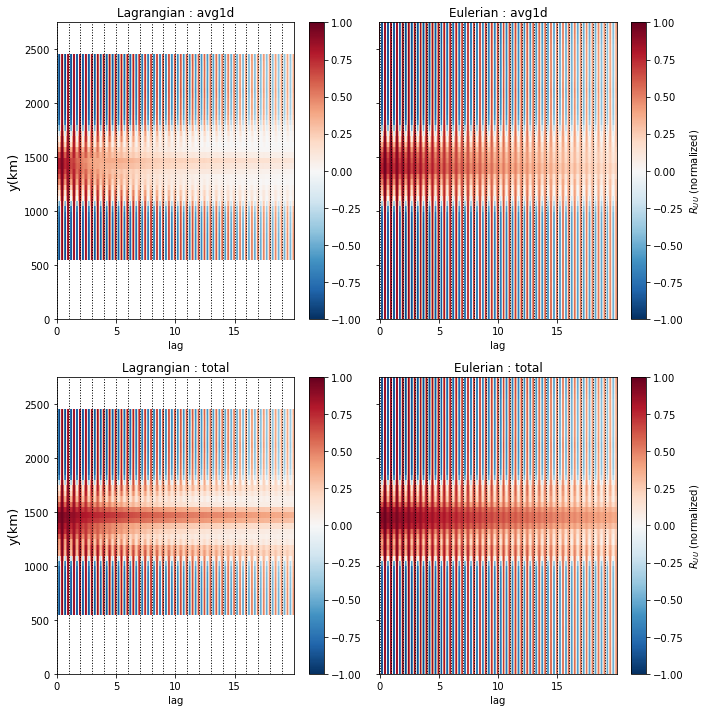

In [108]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for V,i in zip(['avg1d','total'],range(2)):
    corrL[V]['uu_normalized'].plot(ax=ax[i,0],cbar_kwargs={'label':''});ax[i,0].set_ylabel('')
    corrE[V]['uu_normalized'].plot(ax=ax[i,1],cbar_kwargs={'label':r'$R_{UU}$ (normalized)'});ax[i,1].set_ylabel('')
    [ax[i,0].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,20,2*0.5)]
    ax[i,0].set_title('Lagrangian : '+V);ax[i,0].set_ylabel('y(km)',fontsize=13)
    [ax[i,1].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,20,2*0.5)]
    ax[i,1].set_title('Eulerian : '+V);ax[i,1].set_yticklabels('')#;ax[i,1].set_ylabel('y(m)',fontsize=15)
fig.tight_layout()
#    ax[i,1].set_xlim(0,10);ax[i,0].set_xlim(0,10)

#### Comments/notes : 
Lagragian and eulerian normalized autocorrelation of u computed using the signal minus the average eulerian field (first line) and the total signal (second line).\
Only difference right in the jet, with slower decay with the whole signal

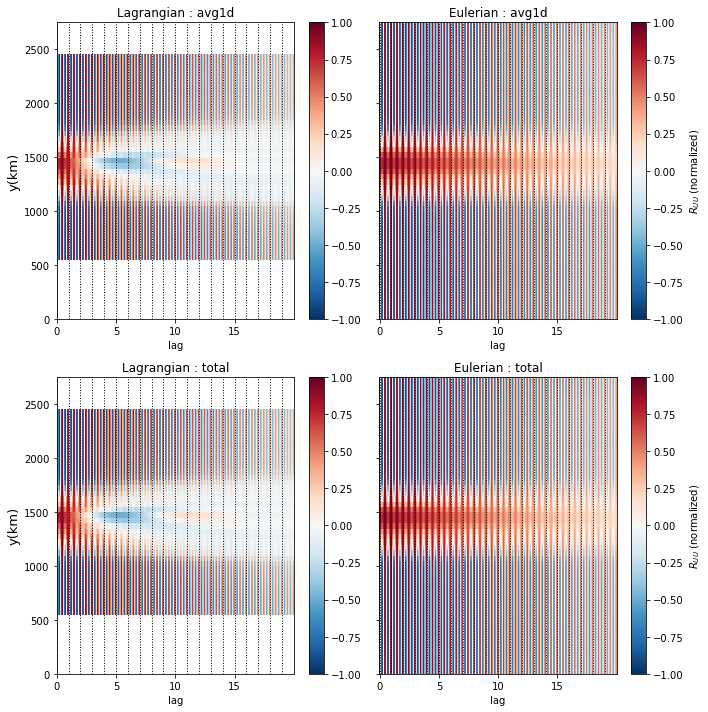

In [109]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
for V,i in zip(['avg1d','total'],range(2)):
    corrL[V]['vv_normalized'].plot(ax=ax[i,0],cbar_kwargs={'label':''});ax[i,0].set_ylabel('')
    corrE[V]['vv_normalized'].plot(ax=ax[i,1],cbar_kwargs={'label':r'$R_{UU}$ (normalized)'});ax[i,1].set_ylabel('')
    [ax[i,0].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,20,2*0.5)]
    ax[i,0].set_title('Lagrangian : '+V);ax[i,0].set_ylabel('y(km)',fontsize=13)
    [ax[i,1].axvline(x,linestyle='dotted',color='k',linewidth=1) for x in np.arange(0,20,2*0.5)]
    ax[i,1].set_title('Eulerian : '+V);ax[i,1].set_yticklabels('')#;ax[i,1].set_ylabel('y(m)',fontsize=15)
fig.tight_layout()

#### Comments/notes : 
No differences this between the two lines, very low mean v in the entire domain.

### Fit

$\widetilde{C} = \widetilde{X}cos(\omega\tau)e^{-\tau/\tilde{T}}$\
$\overline{C} = \overline{X}cos(\Omega\tau)e^{-\tau/\bar{T}}$\
$C = \widetilde{C}+\overline{C}$

In [110]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb):
    return np.exp(-t/Tb)#*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar):
    return Xbar*Cbar(t,Tb)+Xtilde*Ctilde(t,Tt)

In [111]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov

In [112]:
from inspect import signature
import scipy


# Parameters
myfunc = C #function to use for the fit
bounds = ((1,0,0,0),np.inf) # bounds for the fit to avoid non physical results
ce,cl = 'lightseagreen','firebrick'

In [113]:
out_combL_avg,out_combE_avg = {},{}
for V in ['uu','vv'] :
    out_combL_avg[V] = xr.concat([fit(corrL['avg1d'][V].lag,corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg[V] = xr.concat([fit(corrE['avg1d'][V].lag,corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

In [114]:
for V in ['uu','vv'] :
    out_combE_avg[V] = out_combE_avg[V].assign_coords({'ybin':out_combE_avg[V].ybin.values*1e-3})

In [115]:
for V in ['uu','vv']:
    out_combE_avg[V+'_normalized'] = out_combE_avg[V].fitted/out_combE_avg[V].fitted.sel(lags=0)
    out_combL_avg[V+'_normalized'] = out_combL_avg[V].fitted/out_combL_avg[V].fitted.sel(lags=0)

### Fig 6 : Lagrangian and eulerian autocorrelation at 3 three ybins and the corresponding best fit found

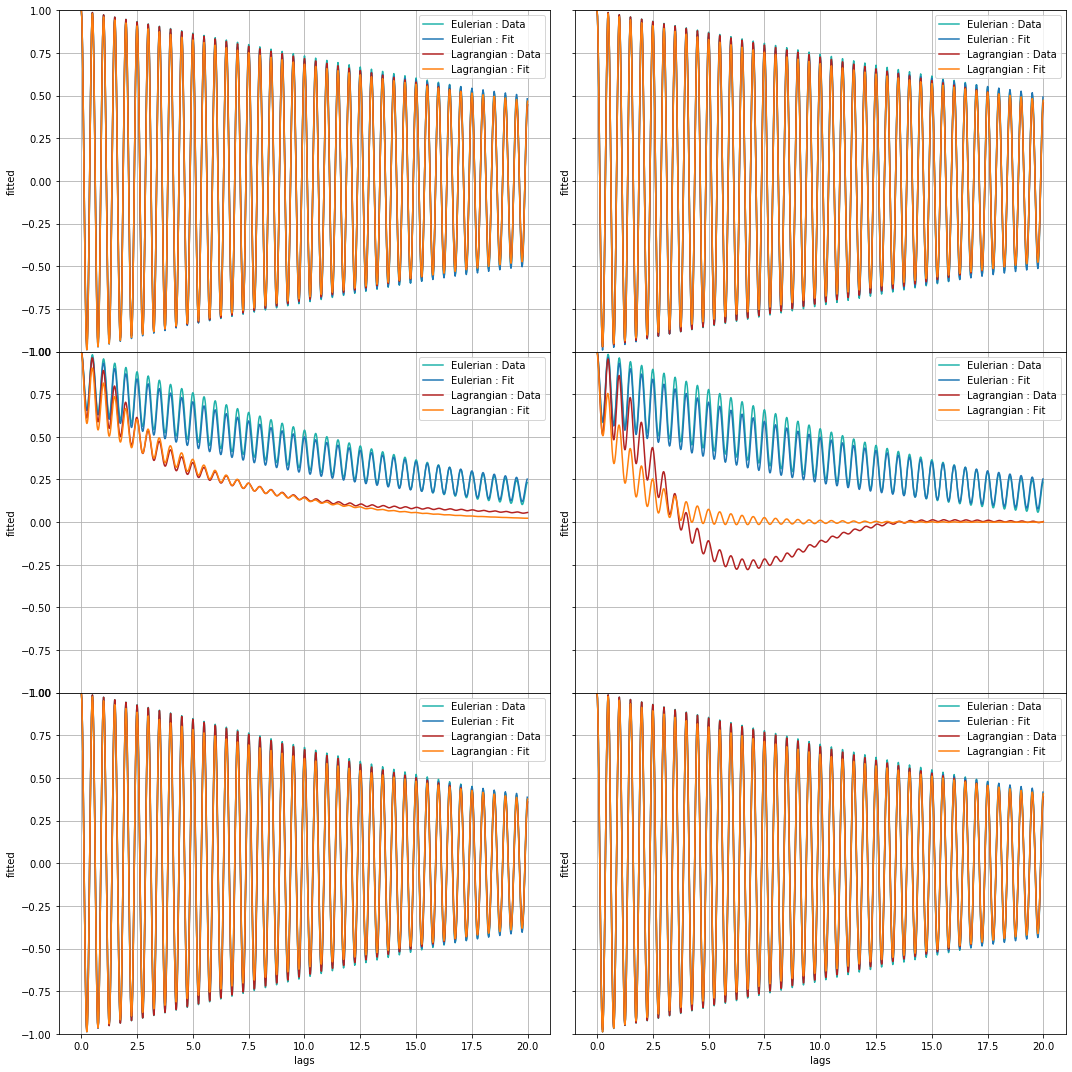

In [116]:
#Sections
Y=[700,1500,2300]
fig,axs = plt.subplots(3,2,figsize=(15,15),sharex=True, sharey=True,gridspec_kw={'hspace': 0})
for i,y in enumerate(Y):
    for V,ax in zip(['uu','vv'],axs[i,:]):
        corrE['avg1d'][V+'_normalized'].sel(y_bins=y*1e3,method='nearest').plot(c=ce,ax=ax,label=('Eulerian : Data'))
        out_combE_avg[V+'_normalized'].sel(ybin=y,method='nearest').plot(ax=ax,label=('Eulerian : Fit'))
        corrL['avg1d'][V+'_normalized'].sel(y_bins=y,method='nearest').plot(c=cl,ax=ax,label=('Lagrangian : Data'))
        out_combL_avg[V+'_normalized'].sel(ybin=y,method='nearest').plot(ax=ax,label=('Lagrangian : Fit'))
        ax.set_ylim(-1,1);ax.grid();ax.legend();ax.set_title('')
    #axs[0].text(-4,0,name,fontsize=20,rotation=90)
    #axs[0].set_title('uu');axs[1].set_title('vv')#;axs[0,2].set_title('uv');axs[0,3].set_title('vu')
    #plt.suptitle(title,x=.55,y=1,fontsize=20)
    fig.tight_layout()

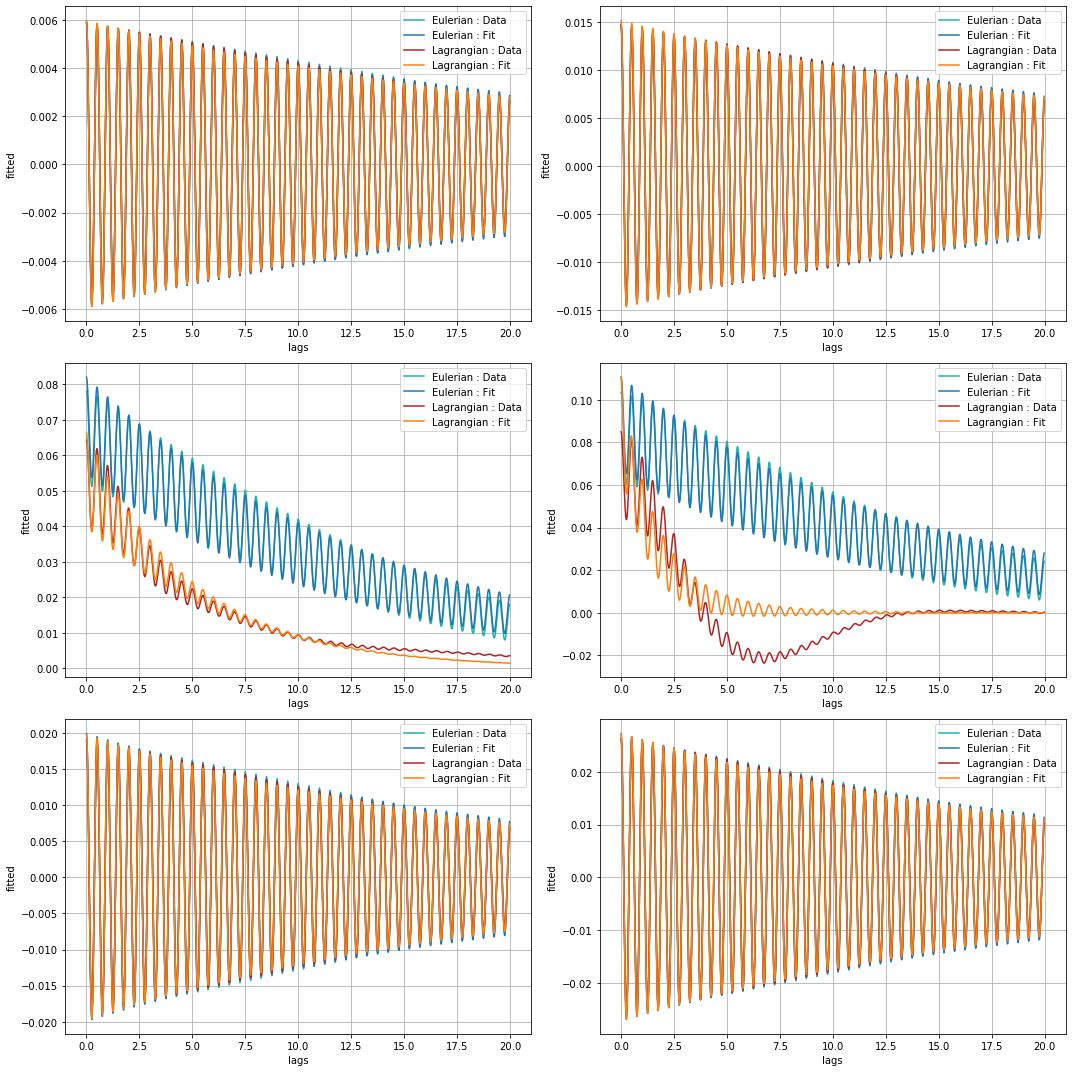

In [117]:
#Sections
Y=[700,1500,2300]
fig,axs = plt.subplots(3,2,figsize=(15,15))
for i,y in enumerate(Y):
    for V,ax in zip(['uu','vv'],axs[i,:]):
        corrE['avg1d'][V].sel(y_bins=y*1e3,method='nearest').plot(c=ce,ax=ax,label=('Eulerian : Data'))
        out_combE_avg[V].fitted.sel(ybin=y,method='nearest').plot(ax=ax,label=('Eulerian : Fit'))
        corrL['avg1d'][V].sel(y_bins=y,method='nearest').plot(c=cl,ax=ax,label=('Lagrangian : Data'))
        out_combL_avg[V].fitted.sel(ybin=y,method='nearest').plot(ax=ax,label=('Lagrangian : Fit'))
        ax.grid();ax.legend();ax.set_title('');
    #axs[0].text(-4,0,name,fontsize=20,rotation=90)
    #axs[0].set_title('uu');axs[1].set_title('vv')#;axs[0,2].set_title('uv');axs[0,3].set_title('vu')
    #plt.suptitle(title,x=.55,y=1,fontsize=20)
    fig.tight_layout()

#### Comments/notes : 
Same figure that previous one but with non normalized autocorrelation (choose btw the 2)

### Fig 7 : Estimation of the parameters depending on y

In [127]:
lims_uu = [(0,30),(0,0.1),(0,25),(0,0.1)]#,(-0.01,0.05)]
lims_vv = [(0,30),(0,0.1),(0,25),(0,0.3)]#,(-0.01,0.07)]
titles = [r'$\widetilde{T}$',r'$\widetilde{X}$',r'$\overline{T}$',r'$\overline{X}$']#,r'$\Omega$']

Text(0.5, 0.98, 'Autocorrelation of u')

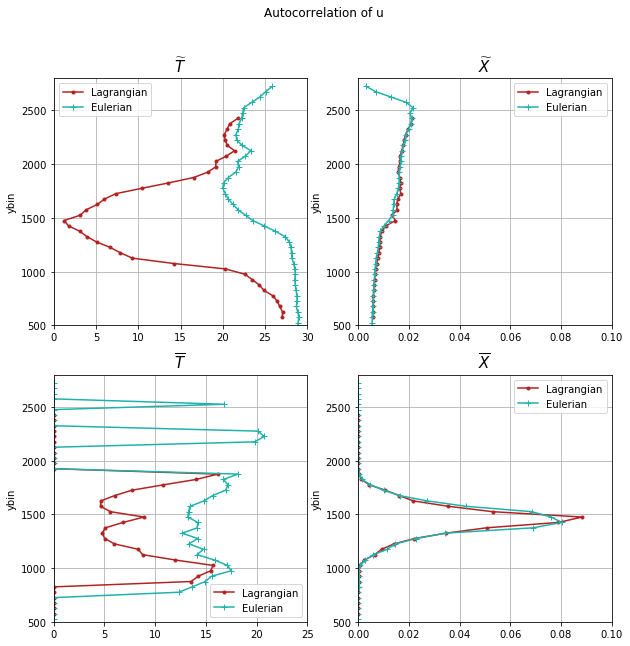

In [121]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_uu[:2],axes[0,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims_uu[2:],axes[1,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.suptitle('Autocorrelation of u')

Text(0.5, 0.98, 'Autocorrelation of v')

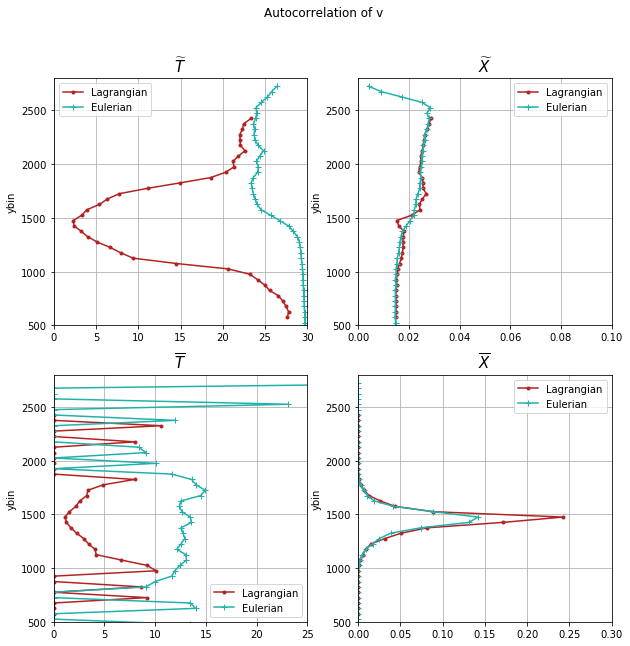

In [128]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims_vv[:2],axes[0,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims_vv[2:],axes[1,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.suptitle('Autocorrelation of v')

In [77]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
